In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import datetime as dt
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

### Main ideas to detect outliers in the divvy bike dataset
Goal: \
The goal is to identify whether bike data during a specific one hour interval on a specific date is an outlier or not. An example is that the number of bikes running between 10:00 and 11:00 on March 21st, 2023 is 4. Is that an outlier or not? 

Methodology: \
To identify if the bike data during a specific one hour interval on a specific date is an outlier or not, bike data should be separately considered based on different pairs of start station and end station. For every single pairs of stations, three dimensions are considered: time, date, and stations. 
- Firstly,since there exists rush hours that leads to more bikes during some time than other time, a time series data that contains the number of bikes going from the start station to the end station at a specific one-hour interval for every day in the first quarter of 2023 is generated. 
- The second time series generated is the number of bikes going from the start station to the end station for every one-hour time interval, i.e. from 0:00 to 24:00, on a specific date. 
- The third data generated is across stations. The number of bikes going from all pairs of stations during a specific one-hour interval on a specific date is found.
- Moving Average is used to detect outliers.

The first function: \
bikes_check_out_by_hour takes start station, end station, and an one-hour interval as input and return the number of bikes running from start station and end station at the specific an hour interval for every single day in the first quarter of 2023. 
 
Pseudo Code:

bikes_check_out_by_hour(start_station, end_station, hour):

    Read the trip data from the first quarter of 2023
    Filter the data by start and end station
    Calculate the checkout time by hour
    Group the data by date and checkout hour to get bike counts
    Generate a time series with all hours in the first quarter of 2023
    Fill in the bike counts for checkout hours in the time series
    Get the bike counts for the specified hour interval
    Return the hour counts


In [2]:
def bikes_check_out_by_hour(start_station, end_station, hour):
    """
    Calculate the number of bikes going between start_station and end_station at a specific hour interval for every day in quarter 1.

    Args:
        start_station (str): The name of the start station.
        end_station (str): The name of the end station.
        hour (str): The specified hour interval in the format 'HH:MM-HH:MM'.

    Returns:
        pd.Series: A pandas Series containing the bike counts for the specified hour interval.

    """
    df1 = pd.read_csv("datasets/202301-divvy-tripdata.csv", parse_dates=["started_at", "ended_at"])
    df2 = pd.read_csv("datasets/202302-divvy-tripdata.csv", parse_dates=["started_at", "ended_at"])
    df3 = pd.read_csv("datasets/202303-divvy-tripdata.csv", parse_dates=["started_at", "ended_at"])
    df = pd.concat([df1, df2, df3])
    df.dropna(inplace=True)
    
    # Filter the data by start and end station
    df = df[(df["start_station_name"] == start_station) & (df["end_station_name"] == end_station)]

    # Get the checkout time by hour
    df["checkout_hour"] = df["started_at"].dt.floor("H")

    # Group by date and checkout hour
    bike_counts = df.groupby(["checkout_hour"])["ride_id"].count()

    # Generate time series data with all hours in March
    idx = pd.date_range(start="2023-01-01", end="2023-03-31", freq="H")
    ts_data = pd.Series(0, index=idx)

    # Fill in bike counts for checkout hours in March
    for checkout_hour, bike_count in bike_counts.iteritems():
        ts_data.loc[checkout_hour] = bike_count

    # Get the bike counts for the specified hour
    hour_counts = ts_data.between_time(hour, hour)

    return hour_counts

The second function: \
bikes_check_out_by_dates takes start station, end station, and a date as input and return the number of bikes going from start station and end station for every single one-hour time interval on a specific date in the first quarter of 2023. 

Pseudo Code:

bikes_check_out_by_date(start_station, end_station, date):
    
    Convert the date to a datetime object
    Calculate the end date as the next day
    Filter the data by start and end station and the specified date
    Calculate the checkout time by hour
    Group the data by date and checkout hour to get bike counts
    Generate a time series with all hours in the specified date
    Join the bike counts with the timestamp dataframe
    Fill in missing bike counts with 0
    Rename the column to 'bike count'
    Return the timestamp and bike counts dataframe


In [3]:
def bikes_check_out_by_date(start_station, end_station, date):
    """
    Calculate the number of bikes checked out between start_station and end_station for each hour of the specified date.

    Args:
        start_station (str): The name of the start station.
        end_station (str): The name of the end station.
        date (str): The date in the format 'YYYY-MM-DD'.

    Returns:
        pd.DataFrame: A pandas DataFrame containing the timestamp and bike counts for each hour of the specified date.

    """
    df1 = pd.read_csv("datasets/202301-divvy-tripdata.csv", parse_dates=["started_at", "ended_at"])
    df2 = pd.read_csv("datasets/202302-divvy-tripdata.csv", parse_dates=["started_at", "ended_at"])
    df3 = pd.read_csv("datasets/202303-divvy-tripdata.csv", parse_dates=["started_at", "ended_at"])
    df = pd.concat([df1, df2, df3])
    df.dropna(inplace=True)
    
    start_date = pd.to_datetime(date)
    end_date = start_date + pd.Timedelta(days=1)
    df = df[(df["start_station_name"] == start_station) & 
            (df["end_station_name"] == end_station) & 
            (df["started_at"] >= start_date) & 
            (df["started_at"] < end_date)]

    # Get the checkout time by hour
    df["checkout_hour"] = df["started_at"].dt.floor("H")

    # Group by date and checkout hour
    bike_counts = df.groupby(["checkout_hour"])["ride_id"].count()

    # Generate time series data with all hours in the specified date
    start_datetime = pd.Timestamp(date)
    end_datetime = start_datetime + pd.Timedelta(days=1)
    idx = pd.date_range(start=start_datetime, end=end_datetime, freq="H")
    ts_data = pd.DataFrame({"timestamp": idx})

    # Join the bike counts with the timestamp dataframe
    ts_data = pd.merge(ts_data, bike_counts, how="left", left_on="timestamp", right_index=True)
    ts_data["ride_id"] = ts_data["ride_id"].fillna(0)
    ts_data.rename(columns={'ride_id': 'bike count'}, inplace=True)

    return ts_data

The third function: \
find_bikes_between_stations takes an one-hour interval and a date as input and return the number of bikes going from every pairs of stations during one hour on a specific date in the first quarter of 2023. 

Pseudo Code:

find_bikes_between_stations(hour, date):

    Split the hour range into start hour and end hour
    Create start time by combining the date and start hour
    Create end time by combining the date and end hour
    Filter the data based on the start time and end time
    Group the data by start and end stations and count the number of bikes
    Reset the index of the resulting DataFrame
    Return the DataFrame with start station, end station, and bike counts



In [4]:
def find_bikes_between_stations(hour, date):
    """
    Find the start station and end station pairs that have bikes checked out between the specified hour and date.

    Args:
        hour (str): The hour range in the format 'HH:MM-HH:MM'.
        date (str): The date in the format 'YYYY-MM-DD'.

    Returns:
        pd.DataFrame: A pandas DataFrame containing the start station, end station, and the number of bikes for each pair.

    """
    df1 = pd.read_csv("datasets/202301-divvy-tripdata.csv", parse_dates=["started_at", "ended_at"])
    df2 = pd.read_csv("datasets/202302-divvy-tripdata.csv", parse_dates=["started_at", "ended_at"])
    df3 = pd.read_csv("datasets/202303-divvy-tripdata.csv", parse_dates=["started_at", "ended_at"])
    df = pd.concat([df1, df2, df3])
    df.dropna(inplace=True)
    
    # Filter the data for the specified hour and date
    start_hour, end_hour = hour.split("-")
    start_time = pd.Timestamp(date + " " + start_hour)
    end_time = pd.Timestamp(date + " " + end_hour)
    

    filtered_df = df[(df["started_at"] >= start_time) & (df["started_at"] < end_time)]

    # Group by start and end stations and count the number of bikes
    bike_counts = filtered_df.groupby(["start_station_name", "end_station_name"]).size().reset_index(name="bike_count")
    bike_counts.reset_index(drop=True, inplace=True)
    
    return bike_counts

In [5]:
# a helper function that concat hour and date to a timestamp

def convertion(hour: str, date: str) -> pd.Timestamp:
    """
    Convert the hour and date strings to a pandas Timestamp object.

    Args:
        hour (str): The hour range in the format 'HH:MM-HH:MM'.
        date (str): The date in the format 'YYYY-MM-DD'.

    Returns:
        pd.Timestamp: The desired Timestamp object with the specified date and hour.

    """
    # Convert date and hour to pandas Timestamp objects
    date = pd.Timestamp(date)
    hour_start, hour_end = hour.split("-")
    hour_start = pd.Timestamp(hour_start)
    hour_end = pd.Timestamp(hour_end)

    # Combine date and hour to get the desired Timestamp
    desired_ts = pd.Timestamp(
        year=date.year,
        month=date.month,
        day=date.day,
        hour=hour_start.hour,
        minute=hour_start.minute,
    )
    return desired_ts

### Outliers Detection
Since it is assumed that the data is streaming data, data that happen/receive after the target timestep is assumed to be unknownn. In this case, moving average and standard deviation method is used and the reference window is set to be 10 data before the target data.


In [6]:
def moving_average(window_size, outlier_threshold, df, target):
    '''
    Using moving average method to detect outliers for streaming data
    '''
    rolling_mean = df['bike count'].rolling(window_size).mean()
    rolling_std = df['bike count'].rolling(window_size).std()

    # Set the ANSI escape code for red text
    red_color_code = '\033[91m'
    # Reset the color back to default
    reset_color_code = '\033[0m'
        
    if rolling_mean.empty or rolling_std.empty:
        print("Not enough data to compute Z-score.")
    else:
        if (target - rolling_mean.iloc[-1]) / rolling_std.iloc[-1] > outlier_threshold:
            print(f"{red_color_code}New data point is an outlier!{reset_color_code}")
        else:
            print("New data point is not an outlier.")


In [7]:
def outlier_across_stations(df, outlier_threshold, target):
    '''
    Using mean and std method to detect outliers for static data for different stations
    '''
    mean = df['bike_count'].mean()
    std = df['bike_count'].std()


    if (target - mean) / std > outlier_threshold:
        # Set the ANSI escape code for red text
        red_color_code = '\033[91m'
        # Reset the color back to default
        reset_color_code = '\033[0m'
        # Print the statement in red
        print(f"{red_color_code}New data point is an outlier!{reset_color_code}")
    else:
        print("New data point is not an outlier.")

In [10]:
def run(hour, date, df):
    '''
    The main function that detects outliers for bike data during a specified one-hour interval on a specified date.
    The function loops every pair of stations at the time and detect outliers.
    '''
    hour_date = convertion(hour,date)
    
    # Sort the routes by trip count in descending order
    bikes_data_station = find_bikes_between_stations(hour, date)
    print("********Detecting if there are outliers on " + str(hour_date) + "********")
    for i in range(bikes_data_station.shape[0]):
        start_station = bikes_data_station.iloc[i,0]
        end_station = bikes_data_station.iloc[i,1]
        
        print("From "+ start_station + " to " + end_station)
    
        bikes_data_hour = pd.DataFrame(bikes_check_out_by_hour(start_station, end_station, hour)).reset_index().rename(columns={'index': 'timestamp', 0: 'bike count'})
        bikes_data_date = bikes_check_out_by_date(start_station, end_station, date)
    
        
        #detect outliers at the same time across days
        target = int(bikes_data_hour[bikes_data_hour.timestamp == hour_date]['bike count'])
        filtered_df = bikes_data_hour.loc[bikes_data_hour['timestamp'] < hour_date]
        print("Comparing with data at the same time across days: ")
        moving_average(10, 3, filtered_df, target)
    
        #detect outliers at the same day across hours
        target = int(bikes_data_hour[bikes_data_hour.timestamp == hour_date]['bike count'])
        filtered_df = bikes_data_hour.loc[bikes_data_hour['timestamp'] < hour_date]
        print("Comparing with data at the same day across hours: ")
        moving_average(10,3, filtered_df, target)
    
        #detect outliers across stations
        target = bikes_data_station[(bikes_data_station.start_station_name == start_station) & (bikes_data_station.end_station_name == end_station)]['bike_count']
        target_location = target.index[0]
        rest_data = bikes_data_station.drop(target_location)
        print("Comparing with data at the same day across stations: ")
        outlier_across_stations(rest_data,3,int(target))


In [11]:
#running the functions
df1 = pd.read_csv("datasets/202301-divvy-tripdata.csv", parse_dates=["started_at", "ended_at"])
df2 = pd.read_csv("datasets/202302-divvy-tripdata.csv", parse_dates=["started_at", "ended_at"])
df3 = pd.read_csv("datasets/202303-divvy-tripdata.csv", parse_dates=["started_at", "ended_at"])
df = pd.concat([df1, df2, df3])

#here is an example
hour = "08:00-09:00"
date = "2023-03-15"
run(hour, date, df)

********Detecting if there are outliers on 2023-03-15 08:00:00********
From 900 W Harrison St to 900 W Harrison St
Comparing with data at the same time across days: 
New data point is an outlier!
Comparing with data at the same day across hours: 
New data point is an outlier!
Comparing with data at the same day across stations: 
New data point is an outlier!
From 900 W Harrison St to Halsted St & Roosevelt Rd
Comparing with data at the same time across days: 
New data point is not an outlier.
Comparing with data at the same day across hours: 
New data point is not an outlier.
Comparing with data at the same day across stations: 
New data point is not an outlier.
From Aberdeen St & Jackson Blvd to Canal St & Monroe St
Comparing with data at the same time across days: 
New data point is not an outlier.
Comparing with data at the same day across hours: 
New data point is not an outlier.
Comparing with data at the same day across stations: 
New data point is not an outlier.
From Aberdeen S

### Data Visualization

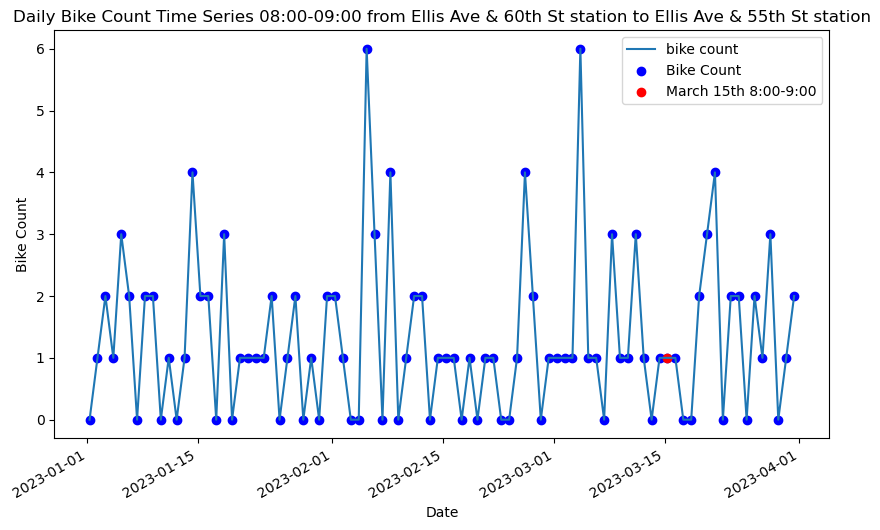

In [24]:
# Plot the data
bikes_data_hour.plot(x='timestamp', y='bike count', figsize=(10, 6))

# Find the index position of the desired data point
desired_data_point = bikes_data_hour[(bikes_data_hour['timestamp'] == '2023-03-15 08:00:00')].index[0]

# Highlight the desired data point as a red dot
plt.scatter(bikes_data_hour['timestamp'], bikes_data_hour['bike count'], color='blue', label='Bike Count')
plt.scatter(bikes_data_hour['timestamp'].iloc[desired_data_point], bikes_data_hour['bike count'].iloc[desired_data_point], color='red', label='March 15th 8:00-9:00')

# Add labels and title to the plot
plt.xlabel('Date')
plt.ylabel('Bike Count')
plt.title('Daily Bike Count Time Series 08:00-09:00 from Ellis Ave & 60th St station to Ellis Ave & 55th St station')

# Show the plot
plt.legend()
plt.show()


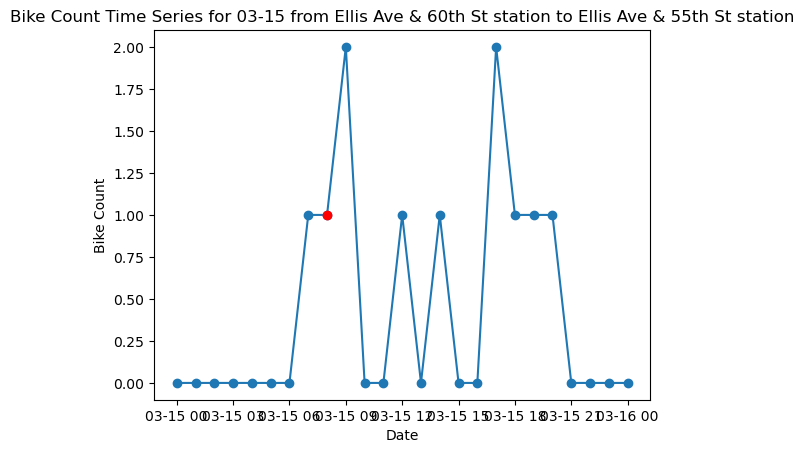

In [27]:
# plot the data
plt.plot(bikes_data_date['timestamp'], bikes_data_date['bike count'], '-o')

# find the index of the desired point (March 15th 8:00-9:00)
desired_point_idx = bikes_data_date.loc[bikes_data_date['timestamp'] == '2023-03-15 08:00:00'].index[0]

# plot a red dot at the desired point
plt.plot(bikes_data_date.loc[desired_point_idx, 'timestamp'], bikes_data_date.loc[desired_point_idx, 'bike count'], 'ro')

# add labels and title to the plot
plt.xlabel('Date')
plt.ylabel('Bike Count')
plt.title('Bike Count Time Series for 03-15 from Ellis Ave & 60th St station to Ellis Ave & 55th St station')

# show the plot
plt.show()

